In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

In [12]:
import csv

In [6]:
# Network Parameters
num_input = 6
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [21]:
#iPhoneSensors_T1_ID1_1L_GD.csv
with open("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_GD.csv", "r") as csvfile:
    reader = csv.reader(csvfile) # 读取csv文件，返回的是迭代类型
    dataset = [row[17:23] for row in reader]
    print(len(dataset))
    print(dataset[:10])


2222
[['-0.019518', '0.008494', '-0.028465', '-0.005996', '0.020669', '-0.004296'], ['-0.005692', '0.000057', '-0.024276', '-0.000256', '0.014950', '0.001150'], ['0.007102', '0.005360', '-0.023330', '0.004456', '0.016611', '-0.002063'], ['-0.000434', '0.001039', '-0.028566', '0.006550', '0.017119', '-0.000400'], ['-0.001535', '-0.011660', '-0.027445', '0.005630', '0.018032', '0.000301'], ['0.003800', '-0.013711', '-0.020021', '0.005064', '0.016065', '-0.000907'], ['-0.015345', '-0.009429', '-0.015628', '0.004625', '0.014716', '-0.003756'], ['-0.015340', '-0.008360', '-0.014566', '0.002188', '0.016319', '0.000343'], ['-0.006906', '-0.021035', '-0.006022', '0.004755', '0.016605', '0.004856'], ['-0.000459', '-0.003021', '-0.005078', '0.007958', '0.009406', '-0.000746']]


In [25]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile) # 读取csv文件，返回的是迭代类型
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)

In [26]:
data_x = read_sensor("weallwalk/sensor/iPhoneSensors_T1_ID1_1L_GD.csv")
print(len(data_x))

2222


In [42]:
f = open("weallwalk/xml/T1_ID1_GD.xml")
length = len(data_x)

cts = f.read()
f.close()

p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
all_foot = p_foot.findall(cts)

p_time = re.compile(r'<Time>(.*?)</Time>')
all_time = p_time.findall(cts)

strike_times = []
#L-1 R-0
strike_times.append([0.0, 0.5])
for i in range(len(all_foot)):
    if(all_foot[i]=='L'):
        strike_times.append([float(all_time[i]), 1])
    else:
        strike_times.append([float(all_time[i]), 0])
strike_times.append([length/25.0, 0.5])
print(strike_times[0:10])
print(len(strike_times))

window_y = []
strike_index=0
for i in range(length):
    if(i/25.0 >= strike_times[strike_index+1][0]):
        strike_index += 1
    window_y.append([strike_times[strike_index][1]])
    
p_dir = re.compile(r'<Direction>(.*?)</Direction>')
all_dir = p_dir.findall(cts)

p_starttime = re.compile(r'<StartTime>(.*?)</StartTime>')
all_starttime = p_starttime.findall(cts)

p_endtime = re.compile(r'<EndTime>(.*?)</EndTime>')
all_endtime = p_endtime.findall(cts)

for i in range(len(all_dir)):
    if(all_dir[i][:4]=='Turn'):
        start_time = int(float(all_time[i])*25)
        end_time = int(float(all_time[i])*25)
        for t in range(start_time-1, end_time):
            window_y[t] = [0.5]

print(len(window_y))

[[0.0, 0.5], [4.271, 0], [4.8239, 1], [5.4414, 0], [5.872, 1], [6.5525, 0], [7.0746, 1], [7.8224, 0], [8.2142, 1], [8.9517, 0]]
136
2222


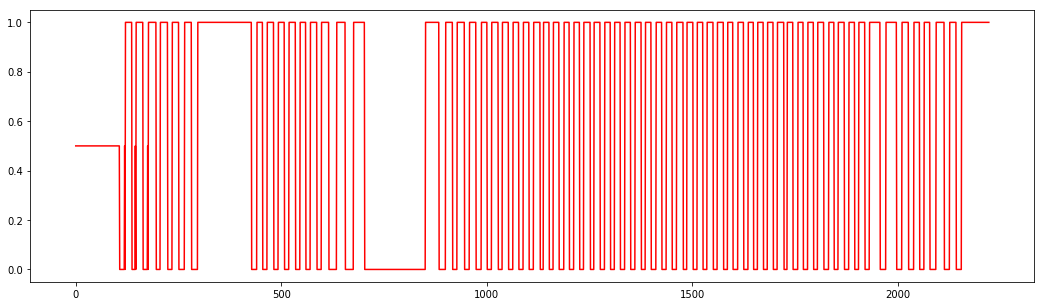

In [44]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in window_y], 'r')
plt.show()

In [7]:
def read_sensor(filename):
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    # rotationRateX,rotationRateY,rotationRateZ 17:20
    #userAccelerationX,userAccelerationY,userAccelerationZ 20:23
    data_x = np.array(dataset.iloc[:, 17:23])
    data_y = np.array(dataset.iloc[:, 40:41])

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    cur_dir = 1
    if(all_foot[0] == 'L'):
        cur_dir = 0
    strike_times.append([0.0, cur_dir])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times.append([length/25.0, 0.5])
#     print(strike_times[0:10])
#     print(len(strike_times))

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])
         
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x_part))
    
    data_x, window_y = [], []
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
    
    return data_x, window_y

In [8]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 1, '1L', 'GD'])
#     step_data_list.append([i, 1, '1L', 'WC'])
#     step_data_list.append([i, 1, '2R', 'GD'])
#     step_data_list.append([i, 1, '2R', 'WC'])
#     step_data_list.append([i, 2, '1L', 'WC'])
#     step_data_list.append([i, 2, '2R', 'WC'])
    
print(step_data_list)

[[1, 1, '1L', 'GD'], [2, 1, '1L', 'GD'], [3, 1, '1L', 'GD'], [4, 1, '1L', 'GD'], [5, 1, '1L', 'GD']]


In [10]:
data_x, window_y = [], []
for i in step_data_list:
    data_x_segement, window_y_segement = add_data(i[0], i[1], i[2], i[3])
    data_x.extend(data_x_segement)
    window_y.extend(window_y_segement)
    
print(len(data_x)) 
print(len(window_y))
data_x[:10]

18969
18969


[array([[ -5.69200000e-03,   5.70000000e-05,  -2.42760000e-02,
          -2.56000000e-04,   1.49500000e-02,   1.15000000e-03],
        [  7.10200000e-03,   5.36000000e-03,  -2.33300000e-02,
           4.45600000e-03,   1.66110000e-02,  -2.06300000e-03],
        [ -4.34000000e-04,   1.03900000e-03,  -2.85660000e-02,
           6.55000000e-03,   1.71190000e-02,  -4.00000000e-04],
        [ -1.53500000e-03,  -1.16600000e-02,  -2.74450000e-02,
           5.63000000e-03,   1.80320000e-02,   3.01000000e-04],
        [  3.80000000e-03,  -1.37110000e-02,  -2.00210000e-02,
           5.06400000e-03,   1.60650000e-02,  -9.07000000e-04],
        [ -1.53450000e-02,  -9.42900000e-03,  -1.56280000e-02,
           4.62500000e-03,   1.47160000e-02,  -3.75600000e-03],
        [ -1.53400000e-02,  -8.36000000e-03,  -1.45660000e-02,
           2.18800000e-03,   1.63190000e-02,   3.43000000e-04],
        [ -6.90600000e-03,  -2.10350000e-02,  -6.02200000e-03,
           4.75500000e-03,   1.66050000e-02,   4

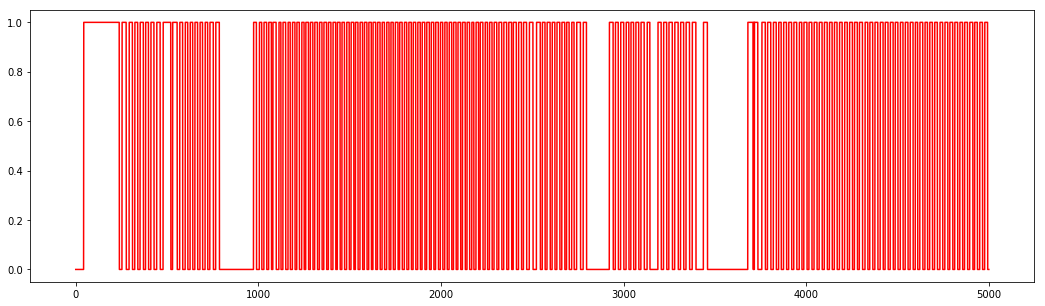

In [7]:
plt.figure(figsize=(18, 5))
start=20000
end=25000
#time back to 0
# plt.plot([i[0][0] for i in data_x[start:end]], [i[0] for i in window_y[start:end]], 'r')
plt.plot([i[0] for i in window_y[start:end]], 'r')
plt.show()

In [8]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

126383


In [9]:
step_test_list = []
for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'GD'])
    step_test_list.append([i, 1, '1L', 'WC'])
    step_test_list.append([i, 1, '2R', 'GD'])
    step_test_list.append([i, 1, '2R', 'WC'])
    step_test_list.append([i, 2, '1L', 'WC'])
    step_test_list.append([i, 2, '2R', 'WC'])
    
print(step_test_list)

[[6, 1, '1L', 'GD'], [6, 1, '1L', 'WC'], [6, 1, '2R', 'GD'], [6, 1, '2R', 'WC'], [6, 2, '1L', 'WC'], [6, 2, '2R', 'WC']]


In [11]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, window_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(window_y_segement)
    
print(len(test_x))
print(len(test_y))

17252
17252


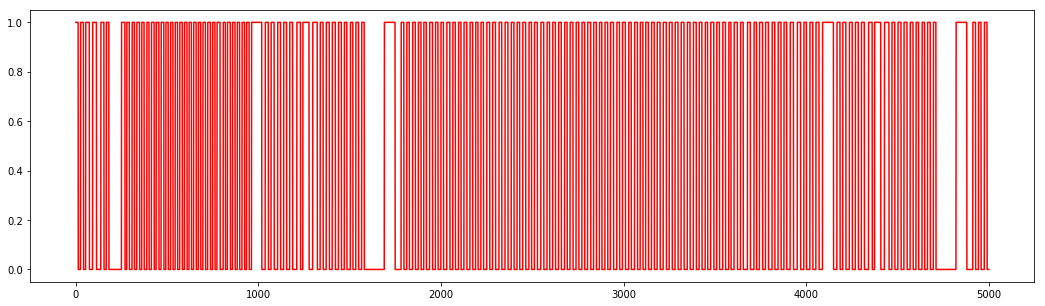

In [12]:
plt.figure(figsize=(18, 5))
start=10000
end=15000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.show()

In [13]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [17]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

126383
126383


In [20]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

training_steps = 6001

126639


In [21]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count/len(y)
#     print("train accuarcy : ", count/len(y))

In [24]:
config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-test-add-data.ckpt-10000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 2000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric.ckpt', global_step=step)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized
Loss at step 0: 13.743861, train accuarcy : 0.000000
Loss at step 200: 0.247586, train accuarcy : 0.550781
Loss at step 400: 0.244138, train accuarcy : 0.621094
Loss at step 600: 0.213478, train accuarcy : 0.656250
Loss at step 800: 0.178983, train accuarcy : 0.746094
Loss at step 1000: 0.140152, train accuarcy : 0.820312
Loss at step 1200: 0.161613, train accuarcy : 0.789062
Loss at step 1400: 0.131577, train accuarcy : 0.828125
Loss at step 1600: 0.130580, train accuarcy : 0.835938
Loss at step 1800: 0.131124, train accuarcy : 0.832031
Loss at step 2000: 0.132368, train accuarcy : 0.835938
Loss at step 2200: 0.118181, train accuarcy : 0.855469
Loss at step 2400: 0.132846, train accuarcy : 0.808594
Loss at step 2600: 0.131534, train accuarcy : 0.808594
Loss at step 2800: 0.098751, train accuarcy : 0.871094
Loss at step 3000: 0.118340, train accuarcy : 0.859375
Loss at step 3200: 0.131220, train accuarcy : 0.839844
Loss at step 3400: 0.127559, train accuarcy : 0.832031
Loss

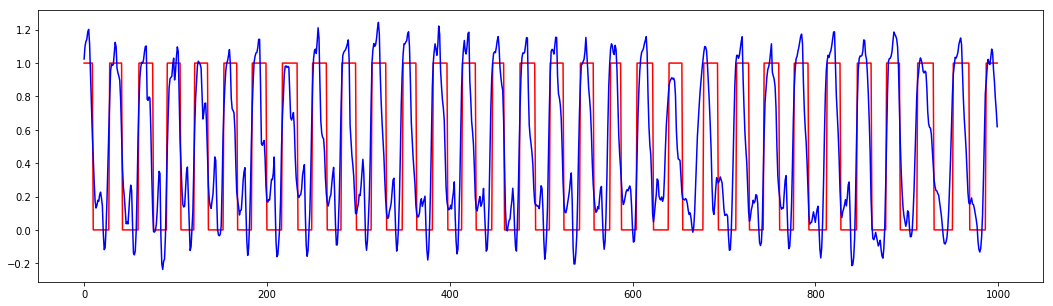

In [25]:
plt.figure(figsize=(18, 5))
start = 13000
end =14000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

In [ ]:
print("test loss : ", test_loss)

count = 0
for i in range(0, len(test_x)):
    if(test_y[i][0] == round(test_logits[i][0])):
        count += 1;
print("test accuarcy : ", count/len(test_x))